# SVM using linear kernels

In [114]:
%matplotlib nbagg

import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

class LinearSVM:
    def __init__(self, num_samples, C=1, h=0.5, maxIter=1000, eta_k=1):
        self.C = C
        self.n = num_samples
        self.h = h
        self.max_iter = maxIter
        self.eta = 0.1*(1.1**eta_k)
        self._obj_vals = []
        self._miss_errs = []
        
    def _huber_loss(self, _X, _y, _w):
        yt = _y * np.dot(_X, _w)
        retval = np.where(yt > (1 + self.h), 0, np.where(yt < (1-self.h), 1 - yt, (1+self.h-yt)**2/(4*self.h)))
        return retval
    
    def _huber_gradient(self, _X, _y, _w):
        yt = _y * np.dot(_X, _w)
        minus_yx = -1*(_y*_X.T).T
        minus_h_to_h = (np.multiply(minus_yx.T,(1+self.h-yt)/(2*self.h))).T
        gradient_vector = np.zeros(_X.shape[1])
        for index, _yt in enumerate(yt):
            loss_at_index = np.zeros(_X.shape[1])
            
            if yt[index] < (1-self.h):
                loss_at_index = minus_yx[index]
            elif yt[index] > (1+self.h):
                loss_at_index = loss_at_index
            else:
                loss_at_index = minus_h_to_h[index]
            gradient_vector = gradient_vector + loss_at_index
                
        return gradient_vector
        
    def compute_obj(self,w):
        yt = np.dot(self.data,w)
        obj = np.power(LA.norm(w),2) + (self.C/self.n)*np.dot(self._huber_loss(self.data, self.target, w), np.ones(self.data.shape[0]))
        return obj;
    
    def compute_grad(self, w):
        return 2*w + (self.C/self.n)*self._huber_gradient(self.data,self.target,w)
    
    def fit(self, X, y):
        self.data = np.dot(X, X.T)
        self.data = np.concatenate((self.data, np.ones(self.data.shape[0])[:,np.newaxis]), axis=1)
        self.target = y
        
        w = np.zeros(self.data.shape[1])
        for iter in range(0, self.max_iter):
            self._obj_vals.append(self.compute_obj(w))
            gradient = self.compute_grad(w)
            self._miss_errs.append((np.multiply(np.dot(self.data,w), self.target) < 0).sum())
            w = w - self.eta*gradient
        
        self._w = w
        return self
    
    def _backtracking_linesearch(obj_fn, grad_fn, w):
        # Large parts referenced from https://gist.github.com/jiahao/1561144#file-optimizer-py-L477
        alpha = 0.0001
        beta = 0.9
        eps = 1.4901161193847656e-08 #got from scipy.sqrt(scipy.finfo(float).eps) in my system
        step = 1.0
        gradient = grad_fn(w)
        
        while obj_fn(w + step * gradient) > obj_fn(w) + alpha * stp * np.dot(gradient, ):
            stp *= beta
        return step
    
    def fit_backtrack(self, X, y):      
        self.data = np.dot(X, X.T)
        self.data = np.concatenate((self.data, np.ones(self.data.shape[0])[:,np.newaxis]), axis=1)
        self.target = y
        
        bt_w = np.zeros(self.data.shape[1])
        for iter in range(0, self.max_iter):
            self._obj_vals.append(self.compute_obj(w))
            gradient = self.compute_grad(w)
            self._miss_errs.append((np.multiply(np.dot(self.data,w), self.target) < 0).sum())
            
            eta = self._backtracking_linesearch(self.compute_obj, self.compute_grad, w)
            w = w - self.eta*gradient
        
        self._w = w
        return self
        

## Observation
The linear svm calculates the dot product between every $ x_{i} $ & $ x_{j} $ in the function fit.  This gram matrix is then used as the input samples for training the SVM.  The rest of the process of a linear kernel is similar to that of the kernel we used in https://github.com/rajegannathan/computational-machine-learning/blob/master/hw5/Gradient%20and%20objective%20functions.ipynb

Due to time constraints I am rewriting gradient-descent in not so generic way.  Major parts are just copied from the original code in the link provided above.

## Generating Gaussian samples

In [101]:
def generate_gaussian_samples(n_samples, m_dimension):
    C = np.random.uniform(low=-1,high=1,size=(m_dimension,m_dimension))
    X = np.r_[np.dot(np.random.randn(int(n_samples/2), m_dimension), C), 
              np.dot(np.random.randn(int(n_samples/2), m_dimension), C) + np.random.randn(m_dimension)]
    
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    y = np.ones(n_samples)
    y[:int(n_samples/2)] = -1
    rng = np.random.RandomState(1999)
    permutation = rng.permutation(n_samples)
    X = X[permutation]
    y = y[permutation]
    return X, y

## Testing my-svm implementation

In [102]:
X_train, y_train = generate_gaussian_samples(500,3)
svm = LinearSVM(X_train.shape[0])
svm.fit(X_train, y_train)

<IPython.core.display.Javascript object>


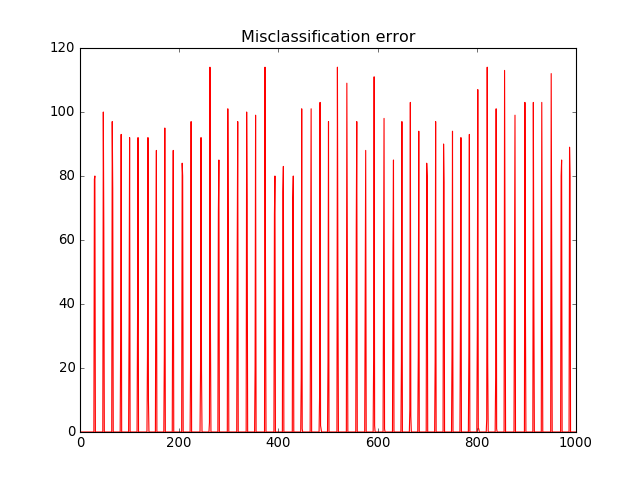

In [103]:
iter = 1000
plt.close()
plt.title("Misclassification error")
plt.plot(range(0,iter), svm._miss_errs[:iter], c='r')

<IPython.core.display.Javascript object>


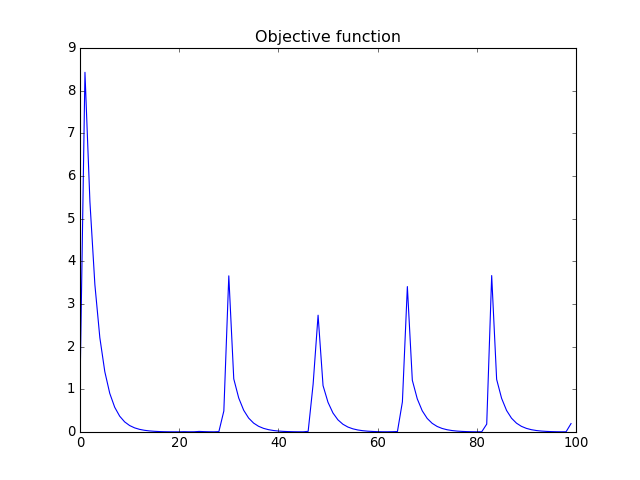

In [104]:
plt.close()
iter = int(1000/10)
plt.title("Objective function")
plt.plot(range(0,iter), svm._obj_vals[:iter])

# Observation
W will be a vector of size m_samples.

In [105]:
print(svm._w.shape)
print(svm._w)

(501,)
[-0.00383433 -0.00496204 -0.00523009  0.00439622 -0.00430413 -0.00448667
  0.00464266  0.00360682 -0.00471358 -0.00452885 -0.00411579 -0.00378596
  0.00548618 -0.00312971 -0.00470632  0.00472123  0.00411863  0.00462012
 -0.00462604 -0.00465733 -0.0036153  -0.00415271  0.0042536  -0.00374615
 -0.00498904  0.00441264  0.00327291 -0.00463972  0.00583759  0.00358056
  0.00448915 -0.00495028  0.00381464 -0.00351639 -0.00571603 -0.00445778
 -0.00415141 -0.00458351  0.00254123  0.00387415 -0.00375358  0.00497232
  0.00457464 -0.00361747 -0.00416259  0.00326261  0.00405295 -0.00427156
  0.00430879 -0.00389025 -0.0047016  -0.00406067 -0.00437485 -0.00392087
  0.00371608  0.00348685  0.00465161  0.00476228 -0.0033622  -0.004849
  0.00420963 -0.00371904  0.00403145 -0.00406224  0.00433217 -0.00553106
 -0.00497331  0.00490789  0.00373855 -0.00382731  0.00480667  0.00446243
 -0.00463384 -0.00420754  0.00396913 -0.00577122  0.00413745 -0.00364969
 -0.00382456 -0.00415367  0.00329404 -0.003004

# Observation
Since the input space has been modified into a higher dimensional space, to plot the points we have to use PCA.  Since we can only take a maximum of three points for visualizing, we are going to do that.

(500, 501)
(501,)
(501, 501)
(500, 3)
(3,)


<IPython.core.display.Javascript object>


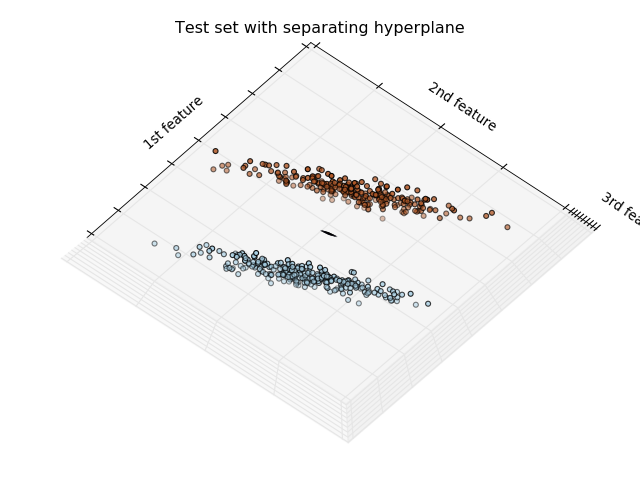

In [110]:
from sklearn.decomposition import PCA


print(svm.data.shape)
print(svm._w.shape)

data = np.concatenate((svm.data, svm._w.reshape(1, svm._w.shape[0])), axis=0)
print(data.shape)

X_display = PCA(n_components=3).fit_transform(data)

w_final = X_display[-1:][0]
X_display = X_display[:-1]
print(X_display.shape)
print(w_final.shape)

plt.close()

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_display[:, 0], X_display[:, 1], X_display[:, 2], c=y_train,cmap=plt.cm.Paired)
ax.set_title("Test set with separating hyperplane")
ax.set_xlabel("1st feature")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd feature")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd feature")
ax.w_zaxis.set_ticklabels([])

x_cord, y_cord = np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100))
z_cord = -1*(w_final[0]*x_cord+w_final[1]*y_cord)/w_final[2]
ax.plot_surface(x_cord, y_cord, z_cord, alpha=0.2)
plt.show()

# Observation
* I have to investigate on why the hyperplane appears so small in the above plot.
* Also, it is pretty clear that we shouldn't arbitrarily iterate for maxIter times as it doesnot provide a proper classification performance.  We need a stopping criteria.
* The oscillation in objective function is most likely because a few 'rogue' points that makes the classification error go high.
* The oscillations can also happen because of the step size being big.  If we reduce the stepsize dynamically, we can reduce the oscillations.
* Backtrack line search modification to gradient descent helps us choose a better line size